### Compare NOS Co-OP atmos. pressure with NHERI pressure
Compare NOS Co-OP atmos. pressure with pressure measured by the UF Sentinel tower, which was deployed at Cedar Key Public beach for the duration of the event (courtesy of my colleague Brian Phillips)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d

In [2]:
datadir = 'F:/crs/proj/2025_NOPP_comparison/helene_water_level/DesignSafe/'
nos_file = 'CO-OPS_8727520_met.csv'
nheri_file = 'atmpressure.csv'

In [3]:
# Read the NOS met data...keep pressure only
def read_met_data(filename):
    # First two lines of the .csv file look like this:
    # "Date","Time (GMT)","Wind Speed (m/s)","Wind Dir (deg)","Wind Gust (m/s)","Air Temp (°C)","Baro (mb)","Humidity (%)","Visibility (km)"
    # "2024/09/24","00:00","1.8","315","3.2","28.8","1011.5","-","-"
    
    df = pd.read_csv(filename)
    # Combine the 'Date' and 'Time (GMT)' columns into a single 'time' column
    df['time'] = pd.to_datetime(df['Date'] + ' ' + df['Time (GMT)'])    
    # Drop the original 'Date' and 'Time (GMT)' columns
    df.drop(columns=["Date", "Time (GMT)","Wind Speed (m/s)","Wind Dir (deg)","Wind Gust (m/s)","Air Temp (°C)","Humidity (%)","Visibility (km)"], inplace=True)
    # Rename the "Baro (mb)" column to "BP"
    df.rename(columns={'Baro (mb)': 'BP'}, inplace=True)
    return df

cedar_key_bp = read_met_data(datadir + nos_file ) # This creates an xarray Dataset
cedar_key_bp['BP'] = cedar_key_bp['BP']/100 # convert our atmos data (in millibars) to decibars
print( cedar_key_bp )

          BP                time
0     10.115 2024-09-24 00:00:00
1     10.115 2024-09-24 00:06:00
2     10.115 2024-09-24 00:12:00
3     10.115 2024-09-24 00:18:00
4     10.116 2024-09-24 00:24:00
...      ...                 ...
1675  10.124 2024-09-30 23:30:00
1676  10.123 2024-09-30 23:36:00
1677  10.124 2024-09-30 23:42:00
1678  10.124 2024-09-30 23:48:00
1679  10.125 2024-09-30 23:54:00

[1680 rows x 2 columns]


In [4]:
# Read the NHERI atm pressure data
def read_nheri_pressure_data(filename):
    # Read the CSV file and parse the 'Time' column as datetime
    df = pd.read_csv(filename, parse_dates=['Time'])
    
    # Rename the columns
    df.rename(columns={'Time': 'time', 'pressure': 'BP'}, inplace=True)
    
    # If you need to convert pressure from millibars to decibars
    df['BP'] = df['BP'] / 100  # Convert pressure to decibars
    
    return df

# Assuming 'datadir' and 'nheri_file' are defined
nheri_bp = read_nheri_pressure_data(datadir + nheri_file)

# Display the result
print(nheri_bp.head())
print(nheri_bp.tail())

# check for NaNs
nnans = nheri_bp['BP'].isna().sum()
print('Nans: ',nnans)
if nnans > 0:
    # Replace NaNs with the average of neighboring values (rolling mean) directly in place
    nheri_bp['BP'] = nheri_bp['BP'].rolling(window=2, min_periods=1).mean()
    # Forward fill and backward fill to replace remaining NaNs
    nheri_bp['BP'] = nheri_bp['BP'].ffill().bfill()
    nnans = nheri_bp['BP'].isna().sum()
    print('Nans now: ',nnans)

                 time         BP
0 2024-09-25 18:00:00  10.099725
1 2024-09-25 18:01:00  10.099715
2 2024-09-25 18:02:00  10.099415
3 2024-09-25 18:03:00  10.099080
4 2024-09-25 18:04:00  10.099510
                    time         BP
4316 2024-09-28 17:56:00  10.113302
4317 2024-09-28 17:57:00  10.112262
4318 2024-09-28 17:58:00  10.112260
4319 2024-09-28 17:59:00  10.112262
4320 2024-09-28 18:00:00  10.112200
Nans:  4
Nans now:  0


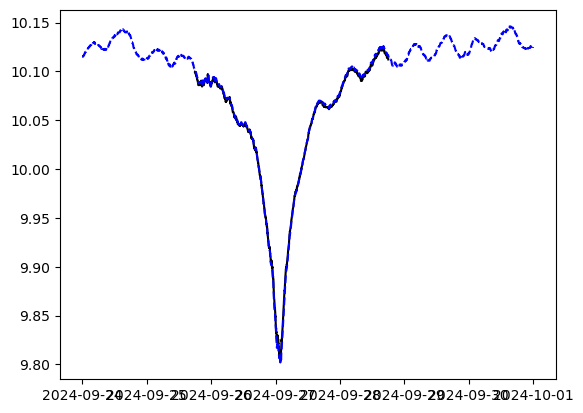

In [5]:
plt.plot(nheri_bp['time'], nheri_bp['BP'], '-k', label='NHERI' )
plt.plot(cedar_key_bp['time'], cedar_key_bp['BP'], '--b', label='NOS CO-OPS')

In [6]:
# This is stupid because it diff even where there is no data

# Create a new dataframe where 'time' is the index (but keep the original intact)
cedar_key_bp_indexed = cedar_key_bp.set_index('time')

# Resample nheri_bp to match the 6-minute interval of cedar_key_bp
nheri_bp_resampled = nheri_bp.set_index('time').resample('6min').mean()  # '6min' for 6-minute resampling

# Now, align the times by reindexing nheri_bp_resampled to the same time index as cedar_key_bp
nheri_bp_resampled = nheri_bp_resampled.reindex(cedar_key_bp_indexed.index, method='nearest')

# Compute the difference between the two dataframes (BP values)
df_diff = nheri_bp_resampled['BP'] - cedar_key_bp_indexed['BP']

# Create a new dataframe to store the result
df_diff_result = pd.DataFrame({
    'time': cedar_key_bp_indexed.index,  # Use the time index from cedar_key_bp
    'pressure_difference': df_diff  # The calculated pressure difference
})

# Summarize the differences
print(df_diff_result.describe())


                                time  pressure_difference
count                           1680          1680.000000
mean   2024-09-27 11:56:59.999999744            -0.009646
min              2024-09-24 00:00:00            -0.043536
25%              2024-09-25 17:58:30            -0.016769
50%              2024-09-27 11:57:00            -0.003769
75%              2024-09-29 05:55:30            -0.001126
max              2024-09-30 23:54:00             0.011866
std                              NaN             0.011686


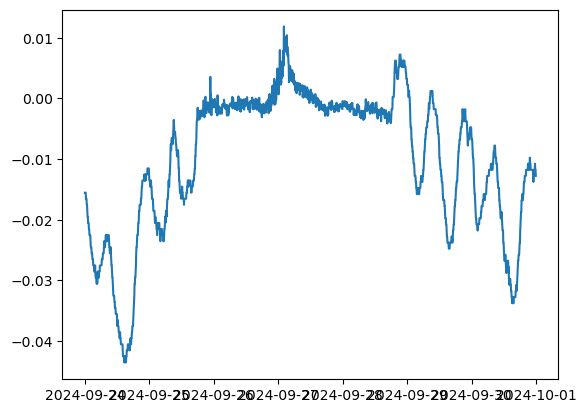

In [7]:
plt.plot(df_diff_result['time'], df_diff_result['pressure_difference'])

2024-09-24 00:00:00
[10.09972532 10.09972002 10.09956505 10.09924781 10.09929531 10.09923094
 10.09896563 10.09859791 10.09820817 10.0982003  10.09820691 10.0982088
 10.09820051 10.09820514 10.09821078 10.09821439 10.0978489  10.09709392
 10.09670778 10.0967005 ]
Filtered nheri_bp values (first 10): [10.09655879 10.09648523 10.09641144 10.09633742 10.09626319 10.09618875
 10.09611412 10.0960393  10.0959643  10.09588914]
[10.09972532 10.09972002 10.09956505 ... 10.11226104 10.112261
 10.11223088]


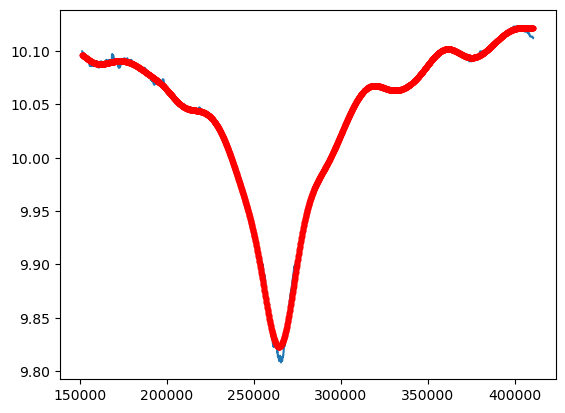

In [8]:
def butter_lowpass_filter(data, cutoff_freq, sample_rate, order=4):
    # Design Butterworth filter
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # Apply filter
    print(data[:20])
    y = filtfilt(b, a, data)
    return y

# Find the common start time (earliest of both datasets)
start_time_common = min(nheri_bp['time'].iloc[0], cedar_key_bp['time'].iloc[0])
print(start_time_common)

# Convert both times to seconds relative to the common start time
time_nheri_bp = (nheri_bp['time'] - start_time_common).dt.total_seconds().values
time_cedar_key_bp = (cedar_key_bp['time'] - start_time_common).dt.total_seconds().values

# Get the BP values as numpy arrays
nheri_bp_values = nheri_bp['BP'].values
cedar_key_bp_values = cedar_key_bp['BP'].values

# Sampling frequency (1 Hz for nheri_bp)
sample_rate = 1
fs = 1/sample_rate
cutoff_frequency = 1./(6*60)  # Cutoff frequency for the low-pass filter (1/6 minute)
filtered_nheri_bp = butter_lowpass_filter(nheri_bp_values, cutoff_frequency, 1)

print("Filtered nheri_bp values (first 10):", filtered_nheri_bp[:10])

plt.plot(time_nheri_bp, nheri_bp_values)
# plt.plot(time_cedar_key_bp, cedar_key_bp_values)
plt.plot(time_nheri_bp, filtered_nheri_bp, '.r')
print(nheri_bp_values)

In [9]:
# Determine the time range for interpolation, constrained to the nheri_bp range (in seconds)
start_time_sec = np.max([time_cedar_key_bp[0], time_nheri_bp[0]])  # Start from the maximum of both datasets (in seconds)
end_time_sec = np.min([time_cedar_key_bp[-1], time_nheri_bp[-1]])  # End at the minimum of both datasets (in seconds)
print(start_time_sec, end_time_sec)

151200.0 410400.0


In [10]:

# Clip cedar_key_bp to only include times within the nheri_bp time range (in seconds)
cedar_key_bp_in_range = cedar_key_bp[(time_cedar_key_bp >= start_time_sec) & (time_cedar_key_bp <= end_time_sec)]

# Instead of creating a new time series, just use the existing time series and filter it
time_cedar_key_bp_filtered = time_cedar_key_bp[(time_cedar_key_bp >= start_time_sec) & (time_cedar_key_bp <= end_time_sec)]

# Interpolate the filtered nheri_bp data to match the filtered cedar_key_bp time intervals (6-minute sampling)
interpolator = interp1d(time_nheri_bp, filtered_nheri_bp, kind='linear', fill_value='extrapolate')

# Interpolate the filtered data to the filtered cedar_key_bp times (now in the same time base)
interpolated_nheri_bp = interpolator(time_cedar_key_bp_filtered)

# Compute the pressure difference between the filtered and interpolated nheri_bp and cedar_key_bp
pressure_difference = interpolated_nheri_bp - cedar_key_bp_in_range['BP'].values
print(pressure_difference[:10])

[-0.00444121 -0.00488588 -0.00533724 -0.00379317 -0.00425146 -0.00370988
 -0.00316616 -0.00261801 -0.00106319 -0.00149947]


In [11]:
print(cedar_key_bp_in_range['time'])

420    2024-09-25 18:00:00
421    2024-09-25 18:06:00
422    2024-09-25 18:12:00
423    2024-09-25 18:18:00
424    2024-09-25 18:24:00
               ...        
1136   2024-09-28 17:36:00
1137   2024-09-28 17:42:00
1138   2024-09-28 17:48:00
1139   2024-09-28 17:54:00
1140   2024-09-28 18:00:00
Name: time, Length: 721, dtype: datetime64[ns]


In [12]:
# Create a new dataframe to store the result
df_interpdiff_result = pd.DataFrame({
    'time': cedar_key_bp_in_range['time'],  # The time column from cedar_key_bp
    'pressure_difference': pressure_difference  # The calculated pressure difference
})

# Display the result
print(df_interpdiff_result.describe())

                      time  pressure_difference
count                  721           721.000000
mean   2024-09-27 06:00:00            -0.000442
min    2024-09-25 18:00:00            -0.011809
25%    2024-09-26 12:00:00            -0.002407
50%    2024-09-27 06:00:00            -0.001111
75%    2024-09-28 00:00:00             0.000787
max    2024-09-28 18:00:00             0.023722
std                    NaN             0.003779


Text(0, 0.5, 'Difference (NHERI minus NOS; dbar)')

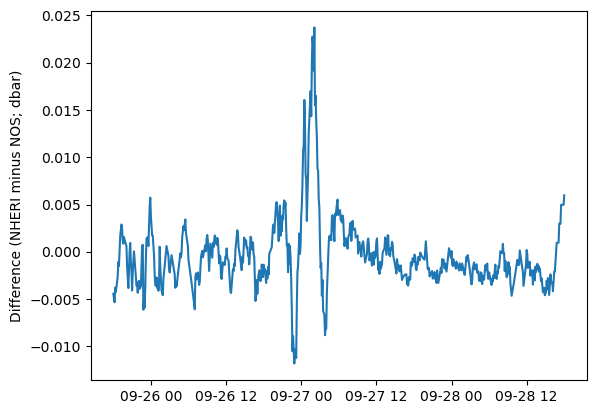

In [16]:
plt.plot(df_interpdiff_result['time'], df_interpdiff_result['pressure_difference'])
plt.ylabel('Difference (NHERI minus NOS; dbar)')